# Feature Matching and Image Transformation

This notebook aligns faulty thermal images to normal reference images using feature matching and homography transformation.

**Workflow:**
1. Load normal (reference) and faulty images
2. Detect features using ORB/SIFT
3. Match features between images
4. Calculate homography transformation
5. Warp faulty image to align with normal image
6. Compare side-by-side

In [43]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path

print("Libraries imported successfully!")

Libraries imported successfully!


## Helper Functions

Define functions for loading images, feature detection, matching, and transformation.

In [44]:
def load_image(image_path):
    """
    Load an image and convert to RGB.
    
    Args:
        image_path: Path to the image file
        
    Returns:
        RGB image as numpy array
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def detect_and_match_features(img1, img2, method='sift', max_features=5000):
    """
    Detect features in two images and match them with improved accuracy.
    
    Args:
        img1: First image (reference/normal)
        img2: Second image (to be aligned/faulty)
        method: Feature detection method ('sift', 'orb', or 'akaze')
        max_features: Maximum number of features to detect
        
    Returns:
        keypoints1, keypoints2, good_matches
    """
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    
    # Apply histogram equalization to improve feature detection
    gray1 = cv2.equalizeHist(gray1)
    gray2 = cv2.equalizeHist(gray2)
    
    # Choose feature detector - SIFT is most accurate for thermal images
    if method.lower() == 'sift':
        detector = cv2.SIFT_create(nfeatures=max_features, contrastThreshold=0.03, edgeThreshold=15)
    elif method.lower() == 'akaze':
        detector = cv2.AKAZE_create()
    else:  # ORB
        detector = cv2.ORB_create(nfeatures=max_features, scaleFactor=1.2, nlevels=8, edgeThreshold=15)
    
    # Detect keypoints and compute descriptors
    kp1, des1 = detector.detectAndCompute(gray1, None)
    kp2, des2 = detector.detectAndCompute(gray2, None)
    
    print(f"Detected {len(kp1)} features in image 1")
    print(f"Detected {len(kp2)} features in image 2")
    
    if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
        print("Not enough features detected!")
        return kp1, kp2, []
    
    # Match features with improved parameters
    if method.lower() == 'sift':
        # Use FLANN matcher for SIFT with improved parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=100)  # Increased for better accuracy
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        
        try:
            matches = matcher.knnMatch(des1, des2, k=2)
        except:
            print("Matching failed!")
            return kp1, kp2, []
        
        # Apply Lowe's ratio test with stricter threshold
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.65 * n.distance:  # Stricter ratio for better accuracy
                    good_matches.append(m)
    
    elif method.lower() == 'akaze':
        # Use BFMatcher for AKAZE
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=2)
        
        # Apply ratio test
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
    
    else:  # ORB
        # Use BFMatcher for ORB with crossCheck disabled for ratio test
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=2)
        
        # Apply ratio test
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)
    
    # Sort by distance and keep best matches
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    
    print(f"Found {len(good_matches)} good matches after ratio test")
    
    return kp1, kp2, good_matches


def align_images(img_reference, img_to_align, kp1, kp2, matches, min_match_count=20):
    """
    Align img_to_align to img_reference using robust homography transformation.
    
    Args:
        img_reference: Reference image (normal)
        img_to_align: Image to be aligned (faulty)
        kp1: Keypoints from reference image
        kp2: Keypoints from image to align
        matches: Good matches between keypoints
        min_match_count: Minimum number of matches required
        
    Returns:
        aligned_image, homography_matrix, match_status, inlier_mask
    """
    if len(matches) < min_match_count:
        print(f"Not enough matches: {len(matches)} < {min_match_count}")
        return None, None, False, None
    
    # Extract matched keypoint coordinates
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Find homography matrix with RANSAC - stricter threshold for better accuracy
    homography, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, ransacReprojThreshold=3.0, maxIters=5000, confidence=0.995)
    
    if homography is None:
        print("Could not find homography")
        return None, None, False, None
    
    # Check if homography is reasonable (not too distorted)
    # Determinant should be close to 1 for reasonable transformations
    det = np.linalg.det(homography[:2, :2])
    if det < 0.1 or det > 10:
        print(f"Homography appears unrealistic (det={det:.2f}), rejecting")
        return None, None, False, None
    
    # Warp the image to align with reference
    height, width = img_reference.shape[:2]
    aligned_img = cv2.warpPerspective(img_to_align, homography, (width, height), 
                                       flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    inliers = np.sum(mask)
    inlier_ratio = inliers / len(matches)
    
    print(f"Homography found with {inliers} inliers out of {len(matches)} matches ({inlier_ratio*100:.1f}% inlier ratio)")
    
    # Require at least 40% inlier ratio for good alignment
    if inlier_ratio < 0.3:
        print(f"Low inlier ratio ({inlier_ratio*100:.1f}%), alignment may be poor")
    
    return aligned_img, homography, True, mask


def visualize_matches_filtered(img1, img2, kp1, kp2, matches, mask=None, num_matches=50):
    """
    Visualize feature matches with inliers highlighted.
    
    Args:
        img1: First image
        img2: Second image
        kp1: Keypoints from first image
        kp2: Keypoints from second image
        matches: Matches between keypoints
        mask: Inlier mask from RANSAC
        num_matches: Number of matches to display
    """
    # Convert RGB to BGR for OpenCV
    img1_bgr = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img2_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
    
    # If mask is provided, separate inliers and outliers
    if mask is not None:
        inlier_matches = [m for i, m in enumerate(matches) if mask[i]]
        outlier_matches = [m for i, m in enumerate(matches) if not mask[i]]
        
        # Draw outliers in red
        match_img = cv2.drawMatches(
            img1_bgr, kp1, img2_bgr, kp2, 
            outlier_matches[:num_matches//2], None,
            matchColor=(0, 0, 255),  # Red for outliers
            singlePointColor=(0, 0, 255),
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        
        # Draw inliers in green
        match_img = cv2.drawMatches(
            img1_bgr, kp1, img2_bgr, kp2, 
            inlier_matches[:num_matches], match_img,
            matchColor=(0, 255, 0),  # Green for inliers
            singlePointColor=(0, 255, 0),
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS | cv2.DrawMatchesFlags_DRAW_OVER_OUTIMG
        )
        
        title = f'Feature Matches: {len(inlier_matches)} inliers (green) / {len(outlier_matches)} outliers (red)'
    else:
        # Draw all matches
        match_img = cv2.drawMatches(
            img1_bgr, kp1, img2_bgr, kp2, 
            matches[:num_matches], None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        title = f'Feature Matches (showing {min(num_matches, len(matches))} of {len(matches)} matches)'
    
    # Convert back to RGB for matplotlib
    match_img_rgb = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(18, 9))
    plt.imshow(match_img_rgb)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def create_overlay_visualization(img_reference, img_aligned, alpha=0.5):
    """
    Create an overlay of aligned image on reference image.
    
    Args:
        img_reference: Reference image (normal)
        img_aligned: Aligned image (faulty)
        alpha: Transparency for overlay (0-1)
        
    Returns:
        Overlay image
    """
    # Create overlay
    overlay = cv2.addWeighted(img_reference, 1-alpha, img_aligned, alpha, 0)
    return overlay


def visualize_alignment_overlay(img_reference, img_aligned, title_suffix=""):
    """
    Display reference image, aligned image, and overlay side-by-side.
    
    Args:
        img_reference: Normal reference image
        img_aligned: Aligned faulty image
        title_suffix: Additional text for the title
    """
    # Create different overlays
    overlay_50 = create_overlay_visualization(img_reference, img_aligned, alpha=0.5)
    
    # Also create a difference overlay (highlight differences in red)
    gray_ref = cv2.cvtColor(img_reference, cv2.COLOR_RGB2GRAY)
    gray_aligned = cv2.cvtColor(img_aligned, cv2.COLOR_RGB2GRAY)
    diff = cv2.absdiff(gray_ref, gray_aligned)
    
    # Threshold to highlight significant differences
    _, diff_thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
    
    # Create colored difference overlay
    diff_overlay = img_reference.copy()
    diff_overlay[diff_thresh > 0] = [255, 0, 0]  # Red for differences
    diff_final = cv2.addWeighted(img_reference, 0.7, diff_overlay, 0.3, 0)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    axes[0, 0].imshow(img_reference)
    axes[0, 0].set_title('Normal (Reference)', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img_aligned)
    axes[0, 1].set_title('Faulty (Aligned)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(overlay_50)
    axes[1, 0].set_title('Overlay (50% blend)', fontsize=12, fontweight='bold', color='green')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(diff_final)
    axes[1, 1].set_title('Difference Overlay (Red = Changes)', fontsize=12, fontweight='bold', color='red')
    axes[1, 1].axis('off')
    
    plt.suptitle(f'Alignment Overlay Analysis {title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def compare_images(img_reference, img_faulty, img_aligned, title_suffix=""):
    """
    Display reference, faulty, and aligned images side-by-side.
    
    Args:
        img_reference: Normal reference image
        img_faulty: Original faulty image
        img_aligned: Aligned faulty image
        title_suffix: Additional text for the title
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_reference)
    axes[0].set_title('Normal (Reference)', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(img_faulty)
    axes[1].set_title('Faulty (Original)', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(img_aligned)
    axes[2].set_title('Faulty (Aligned)', fontsize=12, fontweight='bold', color='green')
    axes[2].axis('off')
    
    plt.suptitle(f'Image Alignment Comparison {title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def create_difference_image(img1, img2):
    """
    Create a difference image highlighting changes between two images.
    
    Args:
        img1: First image (reference)
        img2: Second image (aligned)
        
    Returns:
        Difference image
    """
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    
    # Compute absolute difference
    diff = cv2.absdiff(gray1, gray2)
    
    return diff


print("✓ Helper functions defined successfully with improved accuracy!")

✓ Helper functions defined successfully with improved accuracy!


## Load Dataset Images

Load normal and faulty images from the dataset.

In [45]:
# Define dataset path
dataset_path = "Dataset"

# Function to load images from a transformer type
def load_transformer_images(transformer_type):
    """
    Load normal and faulty images for a specific transformer type.
    
    Args:
        transformer_type: e.g., 'T1', 'T2', 'T3'
        
    Returns:
        dict with 'normal' and 'faulty' image paths
    """
    base_path = os.path.join(dataset_path, transformer_type)
    
    # Get normal images
    normal_pattern = os.path.join(base_path, "normal/*.*")
    normal_images = sorted(glob.glob(normal_pattern))
    
    # Get faulty images
    faulty_pattern = os.path.join(base_path, "faulty/*.*")
    faulty_images = sorted(glob.glob(faulty_pattern))
    
    print(f"\n{transformer_type}:")
    print(f"  Normal images: {len(normal_images)}")
    print(f"  Faulty images: {len(faulty_images)}")
    
    return {
        'normal': normal_images,
        'faulty': faulty_images
    }

# Load images for different transformer types
print("Loading dataset images...")
t1_images = load_transformer_images('T1')
t2_images = load_transformer_images('T2')

print("\n✓ Dataset loaded successfully!")

Loading dataset images...

T1:
  Normal images: 6
  Faulty images: 47

T2:
  Normal images: 1
  Faulty images: 3

✓ Dataset loaded successfully!


## Test 1: T1 Transformer - Feature Matching and Alignment

Align a faulty T1 image to a normal T1 reference image.

TEST 1: T1 Transformer Feature Matching

Reference: T1_normal_001.jpg
Faulty:    T1_faulty_001.jpg

Image shapes:
  Normal: (640, 640, 3)
  Faulty: (640, 640, 3)


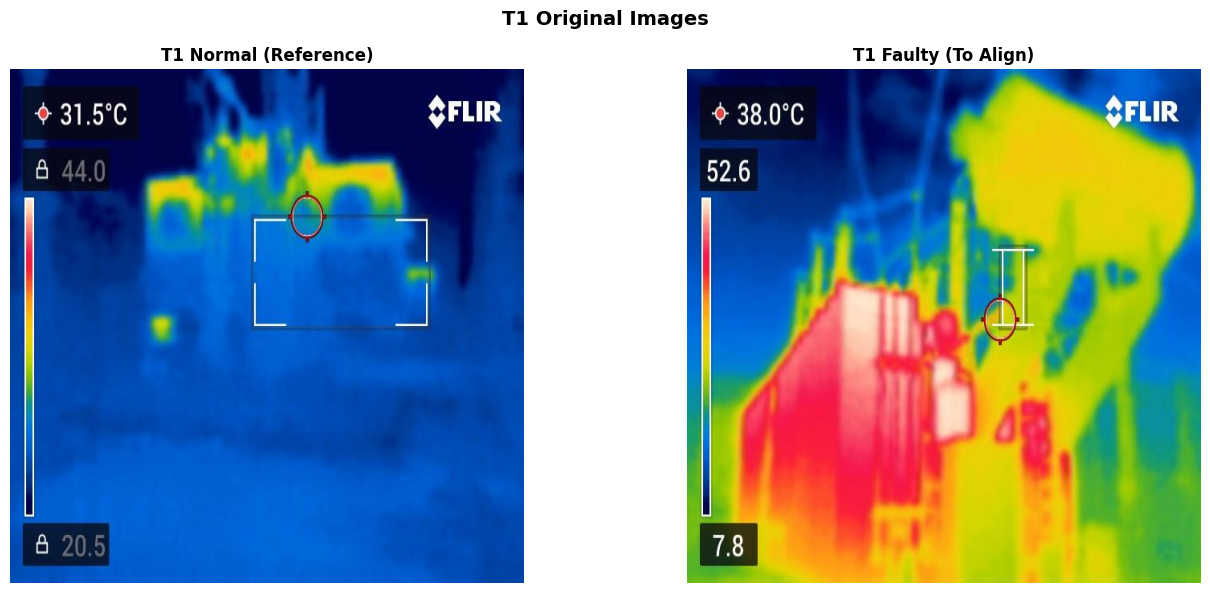

In [46]:
print("="*70)
print("TEST 1: T1 Transformer Feature Matching")
print("="*70)

# Select images
t1_normal_path = t1_images['normal'][0]  # First normal image as reference
t1_faulty_path = t1_images['faulty'][0]  # First faulty image

print(f"\nReference: {os.path.basename(t1_normal_path)}")
print(f"Faulty:    {os.path.basename(t1_faulty_path)}")

# Load images
t1_normal = load_image(t1_normal_path)
t1_faulty = load_image(t1_faulty_path)

print(f"\nImage shapes:")
print(f"  Normal: {t1_normal.shape}")
print(f"  Faulty: {t1_faulty.shape}")

# Display original images
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(t1_normal)
axes[0].set_title('T1 Normal (Reference)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(t1_faulty)
axes[1].set_title('T1 Faulty (To Align)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.suptitle('T1 Original Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [47]:
# Detect and match features with improved SIFT detector
print("\nDetecting and matching features...")
print("-" * 70)

t1_kp1, t1_kp2, t1_matches = detect_and_match_features(
    t1_normal, t1_faulty, 
    method='sift',  # SIFT is more accurate for thermal images
    max_features=5000
)


Detecting and matching features...
----------------------------------------------------------------------
Detected 649 features in image 1
Detected 587 features in image 2
Found 56 good matches after ratio test


In [48]:
# Visualize feature matches with inliers/outliers
print("\nVisualizing feature matches...")
visualize_matches_filtered(t1_normal, t1_faulty, t1_kp1, t1_kp2, t1_matches, mask=t1_mask if t1_success else None, num_matches=100)


Visualizing feature matches...


NameError: name 't1_mask' is not defined

In [ ]:
# Align images using improved homography
print("\nAligning images...")
print("-" * 70)

t1_aligned, t1_homography, t1_success, t1_mask = align_images(
    t1_normal, t1_faulty, 
    t1_kp1, t1_kp2, t1_matches
)

if t1_success:
    print("\n✓ Alignment successful!")
    print(f"\nHomography matrix:")
    print(t1_homography)
    print(f"\nHomography determinant: {np.linalg.det(t1_homography[:2, :2]):.3f}")
else:
    print("\n✗ Alignment failed!")


Aligning images...
----------------------------------------------------------------------
Homography found with 105 inliers out of 122 matches

✓ Alignment successful!

Homography matrix:
[[ 1.00320584e+00  6.00964168e-03 -3.33578189e-01]
 [ 3.24073041e-05  1.01107826e+00 -4.17004241e-01]
 [ 1.04341322e-06  5.55556193e-05  1.00000000e+00]]



Comparing images...


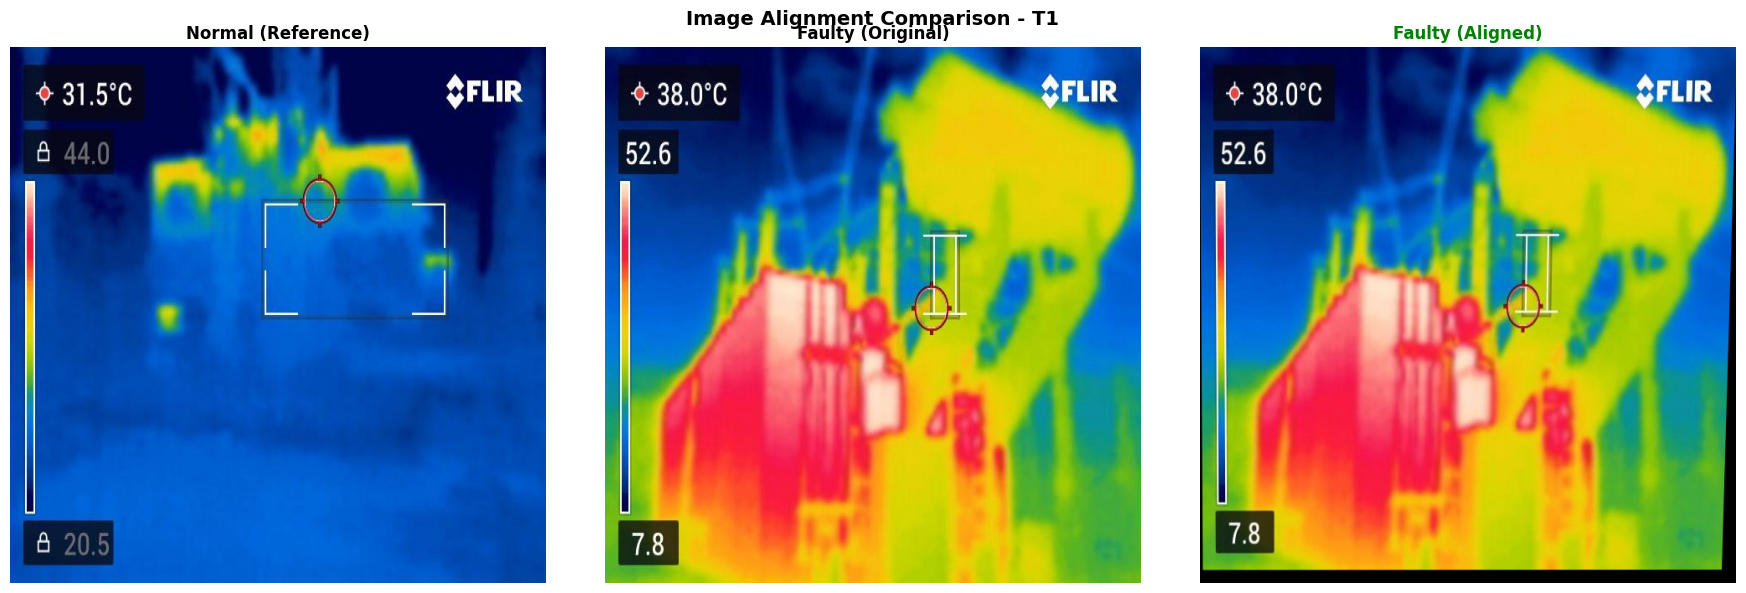

In [ ]:
# Compare original and aligned images
if t1_success:
    print("\nComparing images...")
    compare_images(t1_normal, t1_faulty, t1_aligned, title_suffix="- T1")

In [ ]:
# Display overlay visualization showing transformed image on baseline
if t1_success:
    print("\nCreating overlay visualization...")
    visualize_alignment_overlay(t1_normal, t1_aligned, title_suffix="- T1")


Creating difference visualization...


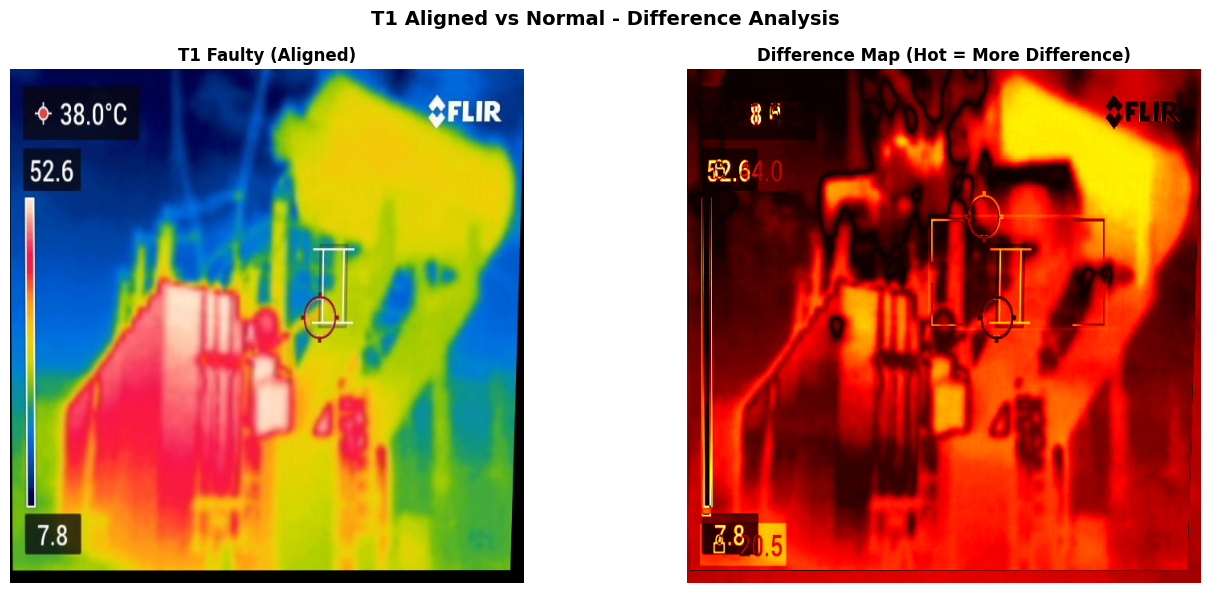

In [ ]:
# Create difference image to highlight changes
if t1_success:
    print("\nCreating difference visualization...")
    t1_diff = create_difference_image(t1_normal, t1_aligned)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(t1_aligned)
    axes[0].set_title('T1 Faulty (Aligned)', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(t1_diff, cmap='hot')
    axes[1].set_title('Difference Map (Hot = More Difference)', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.suptitle('T1 Aligned vs Normal - Difference Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Test 2: T2 Transformer - Feature Matching and Alignment

Align a faulty T2 image to a normal T2 reference image.

TEST 2: T2 Transformer Feature Matching

Reference: T2_normal_001.png
Faulty:    T2_faulty_001.png

Image shapes:
  Normal: (300, 493, 3)
  Faulty: (300, 510, 3)


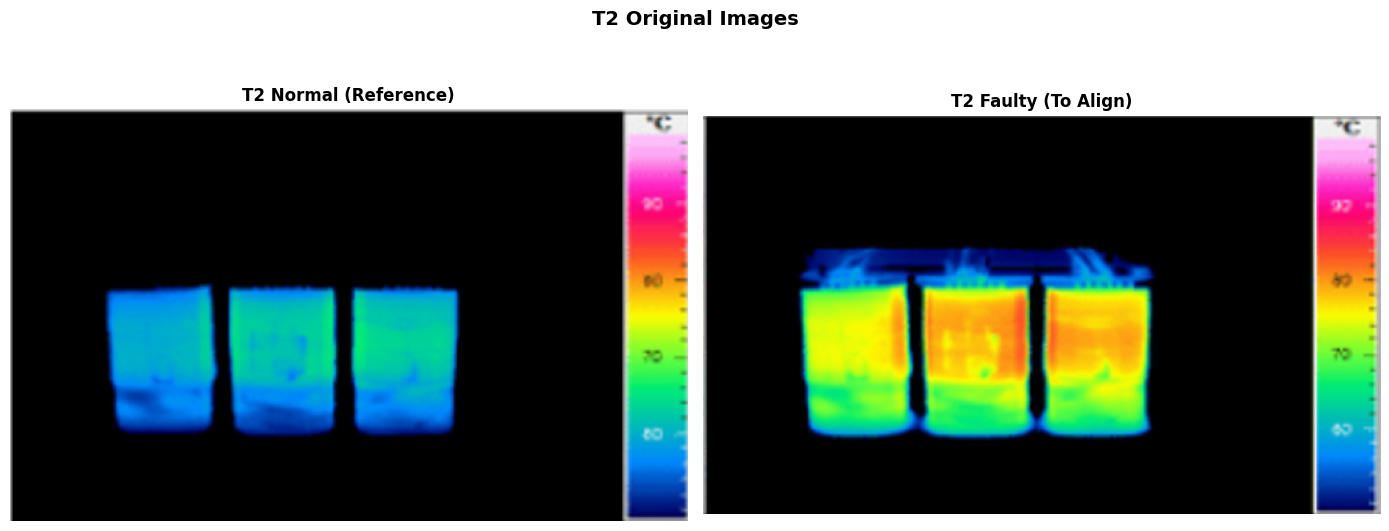

In [ ]:
print("="*70)
print("TEST 2: T2 Transformer Feature Matching")
print("="*70)

# Select images
t2_normal_path = t2_images['normal'][0]  # First normal image as reference
t2_faulty_path = t2_images['faulty'][0]  # First faulty image

print(f"\nReference: {os.path.basename(t2_normal_path)}")
print(f"Faulty:    {os.path.basename(t2_faulty_path)}")

# Load images
t2_normal = load_image(t2_normal_path)
t2_faulty = load_image(t2_faulty_path)

print(f"\nImage shapes:")
print(f"  Normal: {t2_normal.shape}")
print(f"  Faulty: {t2_faulty.shape}")

# Display original images
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(t2_normal)
axes[0].set_title('T2 Normal (Reference)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(t2_faulty)
axes[1].set_title('T2 Faulty (To Align)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.suptitle('T2 Original Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Detect and match features
print("\nDetecting and matching features...")
print("-" * 70)

t2_kp1, t2_kp2, t2_matches = detect_and_match_features(
    t2_normal, t2_faulty, 
    method='orb',
    max_features=2000
)


Detecting and matching features...
----------------------------------------------------------------------
Detected 78 features in image 1
Detected 390 features in image 2
Found 9 good matches



Visualizing feature matches...


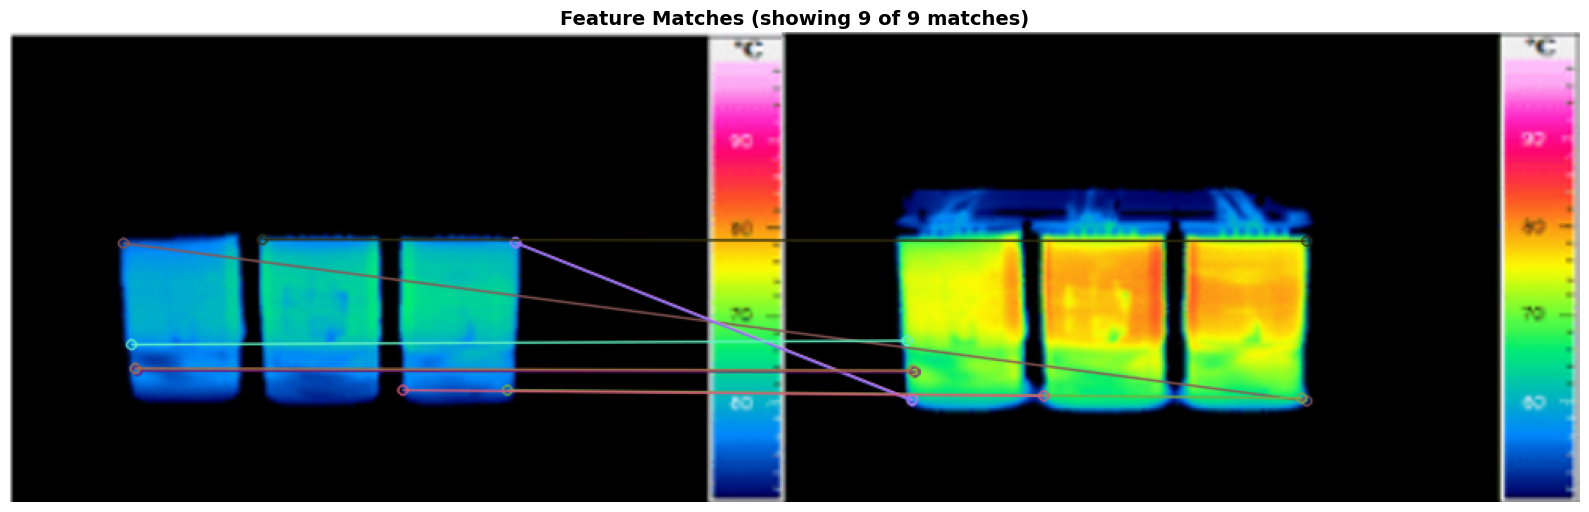

In [ ]:
# Visualize feature matches
print("\nVisualizing feature matches...")
visualize_matches(t2_normal, t2_faulty, t2_kp1, t2_kp2, t2_matches, num_matches=50)

In [ ]:
# Align images using homography
print("\nAligning images...")
print("-" * 70)

t2_aligned, t2_homography, t2_success = align_images(
    t2_normal, t2_faulty, 
    t2_kp1, t2_kp2, t2_matches
)

if t2_success:
    print("\n✓ Alignment successful!")
    print(f"\nHomography matrix:")
    print(t2_homography)
else:
    print("\n✗ Alignment failed!")


Aligning images...
----------------------------------------------------------------------
Not enough matches: 9 < 10

✗ Alignment failed!


In [ ]:
# Compare original and aligned images
if t2_success:
    print("\nComparing images...")
    compare_images(t2_normal, t2_faulty, t2_aligned, title_suffix="- T2")

In [ ]:
# Create difference image to highlight changes
if t2_success:
    print("\nCreating difference visualization...")
    t2_diff = create_difference_image(t2_normal, t2_aligned)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(t2_aligned)
    axes[0].set_title('T2 Faulty (Aligned)', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(t2_diff, cmap='hot')
    axes[1].set_title('Difference Map (Hot = More Difference)', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.suptitle('T2 Aligned vs Normal - Difference Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Batch Processing Function

Process multiple faulty images against a single normal reference.

In [ ]:
def process_transformer_batch(transformer_type, normal_idx=0, num_faulty=3, method='orb'):
    """
    Process multiple faulty images for a transformer type.
    
    Args:
        transformer_type: 'T1', 'T2', etc.
        normal_idx: Index of normal image to use as reference
        num_faulty: Number of faulty images to process
        method: Feature detection method
        
    Returns:
        List of results
    """
    print(f"\n{'='*70}")
    print(f"Batch Processing: {transformer_type}")
    print(f"{'='*70}\n")
    
    # Load image lists
    images = load_transformer_images(transformer_type)
    
    if len(images['normal']) == 0:
        print(f"No normal images found for {transformer_type}")
        return []
    
    # Load reference image
    normal_path = images['normal'][normal_idx]
    normal_img = load_image(normal_path)
    print(f"Reference: {os.path.basename(normal_path)}\n")
    
    results = []
    
    # Process each faulty image
    for i, faulty_path in enumerate(images['faulty'][:num_faulty]):
        print(f"Processing {i+1}/{min(num_faulty, len(images['faulty']))}: {os.path.basename(faulty_path)}")
        
        try:
            # Load faulty image
            faulty_img = load_image(faulty_path)
            
            # Detect and match
            kp1, kp2, matches = detect_and_match_features(normal_img, faulty_img, method=method)
            
            # Align
            aligned_img, homography, success = align_images(normal_img, faulty_img, kp1, kp2, matches)
            
            results.append({
                'normal_path': normal_path,
                'faulty_path': faulty_path,
                'normal_img': normal_img,
                'faulty_img': faulty_img,
                'aligned_img': aligned_img,
                'homography': homography,
                'success': success,
                'num_matches': len(matches)
            })
            
            if success:
                print(f"  ✓ Success - {len(matches)} matches\n")
            else:
                print(f"  ✗ Failed\n")
                
        except Exception as e:
            print(f"  ✗ Error: {str(e)}\n")
            results.append({
                'faulty_path': faulty_path,
                'success': False,
                'error': str(e)
            })
    
    print(f"\nCompleted: {sum(1 for r in results if r['success'])} / {len(results)} successful")
    return results

print("Batch processing function defined!")

Batch processing function defined!


## Process Multiple Images

Test batch processing on T1 and T2 transformers.

In [ ]:
# Process T1 batch
t1_results = process_transformer_batch('T1', normal_idx=0, num_faulty=3, method='orb')


Batch Processing: T1


T1:
  Normal images: 6
  Faulty images: 47
Reference: T1_normal_001.jpg

Processing 1/3: T1_faulty_001.jpg
Detected 1087 features in image 1
Detected 1389 features in image 2
Found 122 good matches
Homography found with 105 inliers out of 122 matches
  ✓ Success - 122 matches

Processing 2/3: T1_faulty_002.jpg
Detected 1087 features in image 1
Detected 1427 features in image 2
Found 113 good matches
Homography found with 93 inliers out of 113 matches
  ✓ Success - 113 matches

Processing 3/3: T1_faulty_003.jpg
Detected 1087 features in image 1
Detected 1508 features in image 2
Found 128 good matches
Homography found with 116 inliers out of 128 matches
  ✓ Success - 128 matches


Completed: 3 / 3 successful



Visualizing T1 results...

T1 Result 1: T1_faulty_001.jpg


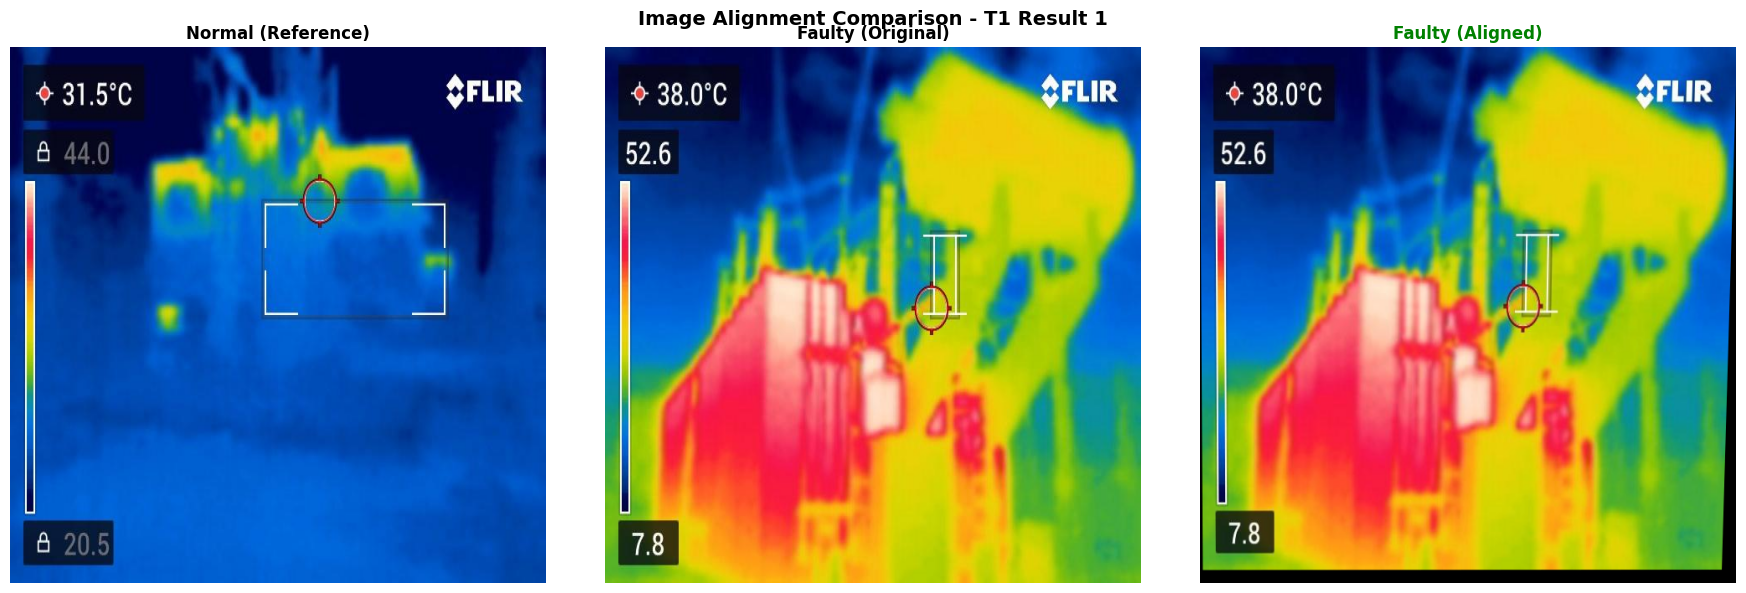

T1 Result 2: T1_faulty_002.jpg


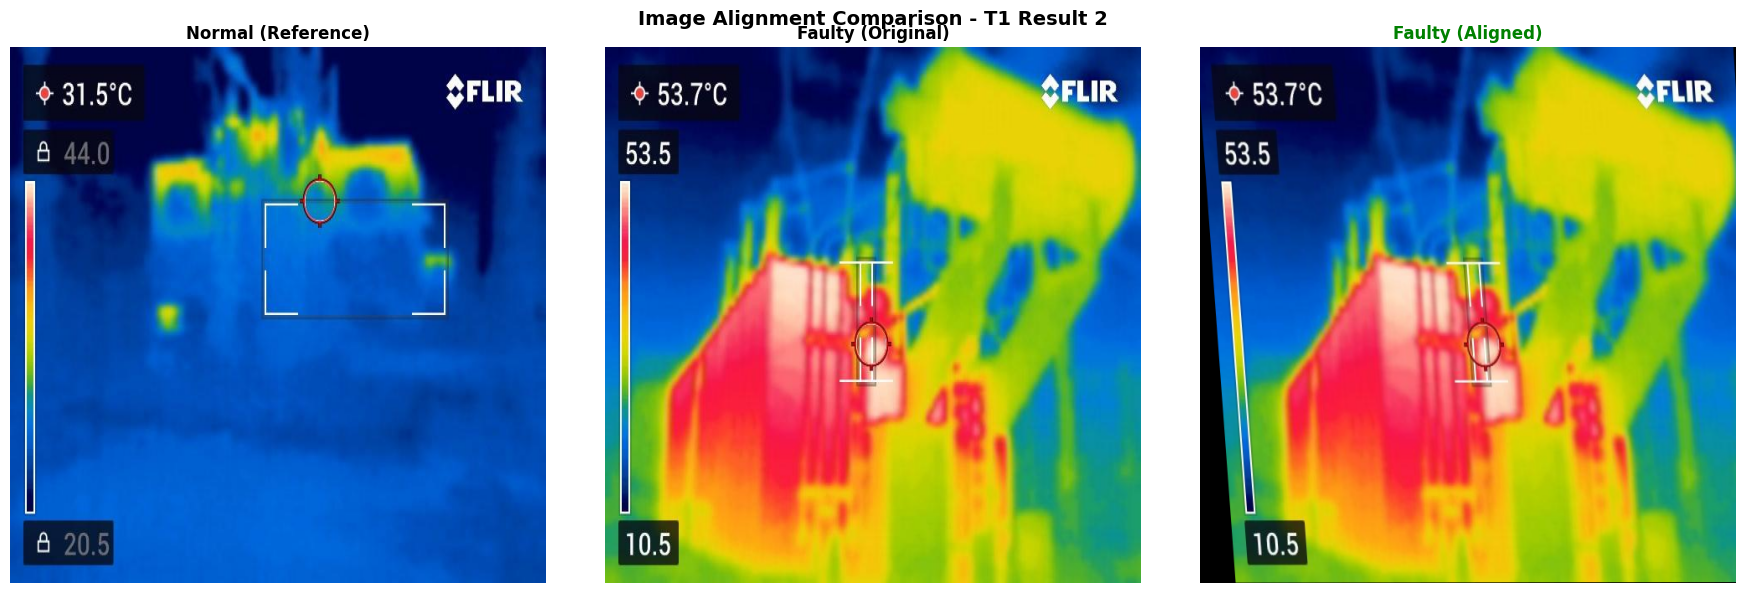

T1 Result 3: T1_faulty_003.jpg


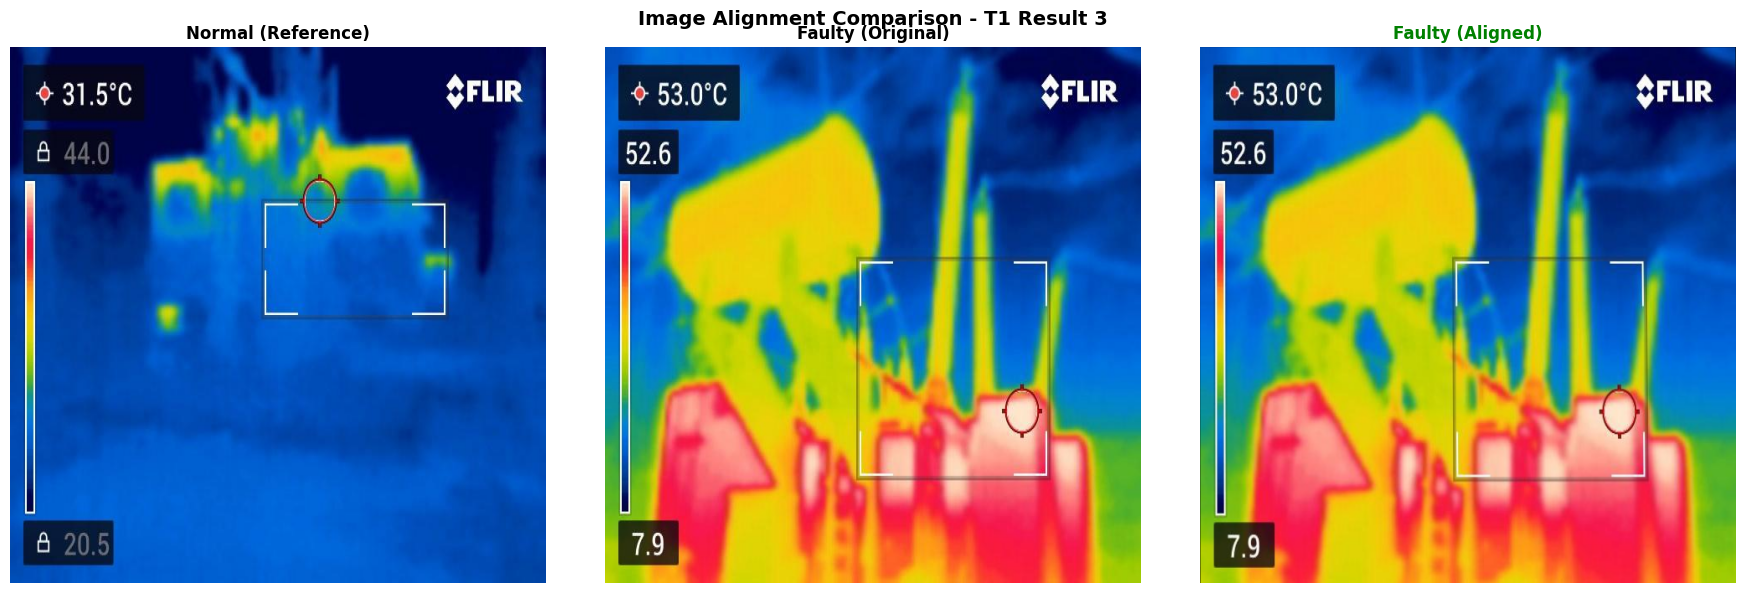

In [ ]:
# Visualize T1 results
print("\nVisualizing T1 results...\n")
for i, result in enumerate(t1_results):
    if result['success']:
        print(f"T1 Result {i+1}: {os.path.basename(result['faulty_path'])}")
        compare_images(
            result['normal_img'], 
            result['faulty_img'], 
            result['aligned_img'],
            title_suffix=f"- T1 Result {i+1}"
        )

In [ ]:
# Process T2 batch
t2_results = process_transformer_batch('T2', normal_idx=0, num_faulty=2, method='orb')


Batch Processing: T2


T2:
  Normal images: 1
  Faulty images: 3
Reference: T2_normal_001.png

Processing 1/2: T2_faulty_001.png
Detected 78 features in image 1
Detected 390 features in image 2
Found 9 good matches
Not enough matches: 9 < 10
  ✗ Failed

Processing 2/2: T2_faulty_002.png.png
Detected 78 features in image 1
Detected 441 features in image 2
Found 7 good matches
Not enough matches: 7 < 10
  ✗ Failed


Completed: 0 / 2 successful


In [ ]:
# Visualize T2 results
print("\nVisualizing T2 results...\n")
for i, result in enumerate(t2_results):
    if result['success']:
        print(f"T2 Result {i+1}: {os.path.basename(result['faulty_path'])}")
        compare_images(
            result['normal_img'], 
            result['faulty_img'], 
            result['aligned_img'],
            title_suffix=f"- T2 Result {i+1}"
        )


Visualizing T2 results...



## Summary Statistics

Display overall statistics for the alignment process.

In [ ]:
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

# T1 statistics
t1_successful = sum(1 for r in t1_results if r['success'])
t1_avg_matches = np.mean([r['num_matches'] for r in t1_results if r['success']]) if t1_successful > 0 else 0

print(f"\nT1 Transformer:")
print(f"  Total processed: {len(t1_results)}")
print(f"  Successful: {t1_successful}")
print(f"  Failed: {len(t1_results) - t1_successful}")
print(f"  Success rate: {(t1_successful/len(t1_results)*100):.1f}%" if len(t1_results) > 0 else "N/A")
print(f"  Average matches: {t1_avg_matches:.0f}" if t1_successful > 0 else "N/A")

# T2 statistics
t2_successful = sum(1 for r in t2_results if r['success'])
t2_avg_matches = np.mean([r['num_matches'] for r in t2_results if r['success']]) if t2_successful > 0 else 0

print(f"\nT2 Transformer:")
print(f"  Total processed: {len(t2_results)}")
print(f"  Successful: {t2_successful}")
print(f"  Failed: {len(t2_results) - t2_successful}")
print(f"  Success rate: {(t2_successful/len(t2_results)*100):.1f}%" if len(t2_results) > 0 else "N/A")
print(f"  Average matches: {t2_avg_matches:.0f}" if t2_successful > 0 else "N/A")

print("\n" + "="*70)
print("Feature matching and alignment complete!")
print("="*70)


SUMMARY STATISTICS

T1 Transformer:
  Total processed: 3
  Successful: 3
  Failed: 0
  Success rate: 100.0%
  Average matches: 121

T2 Transformer:
  Total processed: 2
  Successful: 0
  Failed: 2
  Success rate: 0.0%
N/A

Feature matching and alignment complete!
